# Install libraries

In [25]:
# Only for local use
# install pandas
%pip install -U pandas matplotlib seaborn scikit-learn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.7 MB/s  0:00:011.7 MB/s eta 0:00:01:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.5
    Uninstalling xgboost-3.0.5:
      Successfully uninstalled xgboost-3.0.5
Note: you may need to restart the kernel to use updated packages.


# Load the dataset

In [26]:
# ==============================
# 1) Load Dataset (robust)
# ==============================
import io, pandas as pd


df = pd.read_csv("dark_matter_dataset.csv")
df.columns = [c.strip() for c in df.columns]
print(df.shape); display(df.head())

target_col = "Dark Matter Detected"
assert target_col in df.columns, f"{target_col} not found in columns!"


(2500, 18)


,Galaxy Type,Rotation Curve Shape,Environment,Redshift,Baryonic Mass (Msun),Surface Brightness (mag/arcsec^2),Velocity Dispersion (km/s),HI Line Width (km/s),Outer Curve Slope,Mass-to-Light Ratio,Halo Concentration,Lensing Shear |gamma|,Gas Fraction,Stellar Age (Gyr),Metallicity [Fe/H],Environment Density,TF Residual (mag),Dark Matter Detected
0,Spiral,Declining,Void,0.0944,5.656169e+10,21.907702,229.113228,154.533166,-0.012094,6.612436,6.744551,0.024163,0.398242,4.732682,-0.023948,0.000000,0.081786,0
1,Lenticular,Rising,Group,0.0024,2.064135e+10,21.635825,139.357642,112.849297,-0.000779,2.078952,10.319601,0.026114,0.036021,5.745920,0.102147,0.466958,-0.150522,0
2,Lenticular,Flat,Field,0.0674,1.384287e+11,19.924739,20.000000,162.092320,0.257677,7.188810,9.957997,0.001066,0.172247,8.863495,0.100311,0.121051,-0.028271,0
3,Elliptical,Rising,Group,0.0356,8.472126e+09,22.055595,52.621435,268.988696,0.072788,10.218894,7.867390,0.008146,0.132051,1.940565,0.033625,0.518569,0.061646,0
4,Irregular,Flat,Field,0.0138,2.905254e+09,20.460898,182.194473,201.708247,-0.367943,15.079316,12.198495,0.004566,0.452241,8.571328,0.113278,0.200160,-0.246110,0


# Visualization

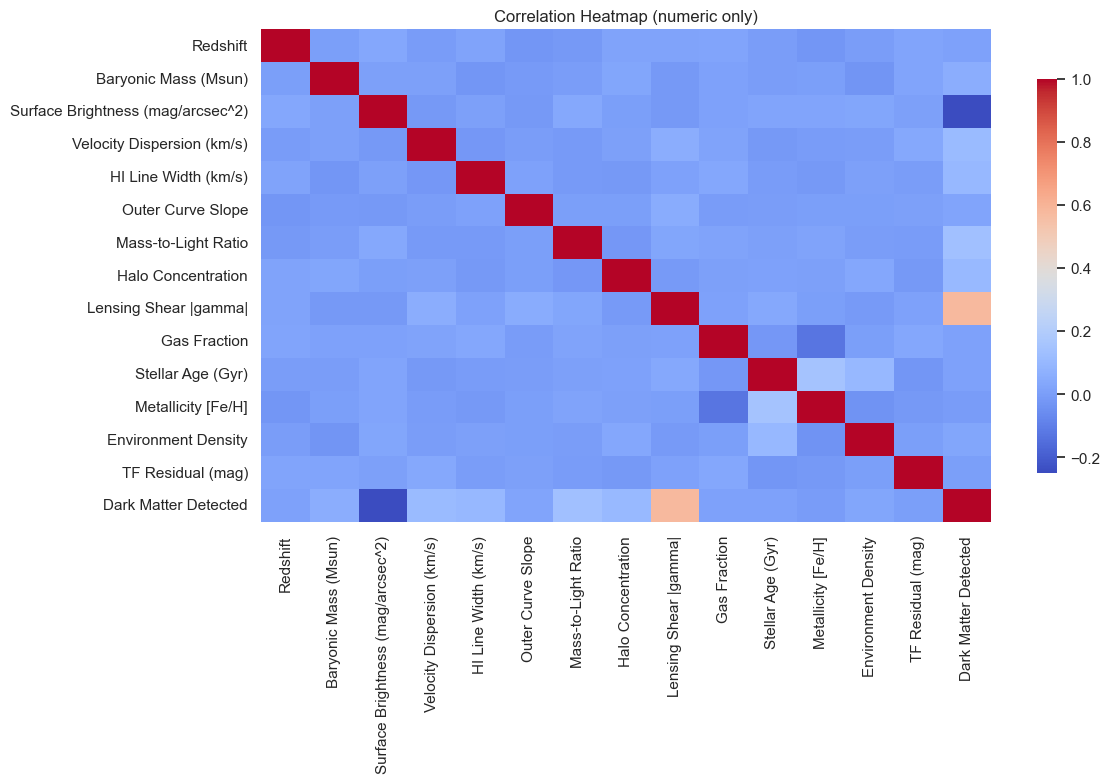

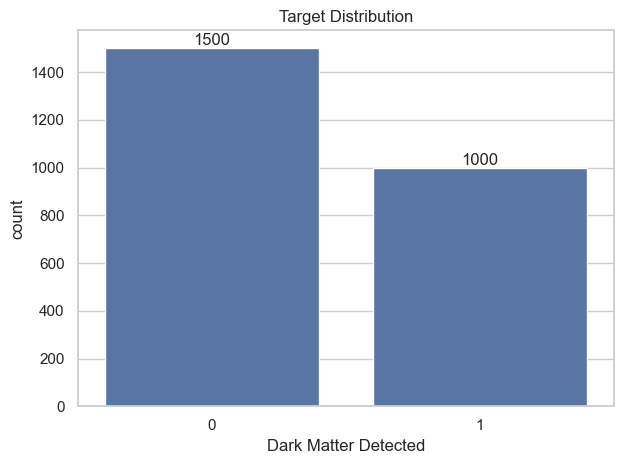

In [27]:
# ==============================
# 2) Quick Visualization (safe)
# ==============================
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")

num_df = df.select_dtypes(include=["number"]).copy()
if target_col not in num_df.columns:
    num_df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

corr = num_df.corr(numeric_only=True)
plt.figure(figsize=(12,8)); sns.heatmap(corr, cmap="coolwarm", annot=False, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap (numeric only)"); plt.tight_layout(); plt.show()

ax = sns.countplot(x=df[target_col].astype(int))
ax.bar_label(ax.containers[0])
plt.title("Target Distribution"); plt.tight_layout(); plt.show()


# Train/Test

In [28]:
# ==============================
# 3) Split + define cat/num (ORDER MATTERS)
# ==============================
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
for force_c in ["Galaxy Type", "Environment", "Rotation Curve Shape"]:
    if force_c in X.columns and force_c not in cat_cols:
        cat_cols.append(force_c)

num_cols = [c for c in X.columns if c not in cat_cols]
print("Categorical:", cat_cols)
print("Numeric:", num_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Categorical: ['Galaxy Type', 'Rotation Curve Shape', 'Environment']
Numeric: ['Redshift', 'Baryonic Mass (Msun)', 'Surface Brightness (mag/arcsec^2)', 'Velocity Dispersion (km/s)', 'HI Line Width (km/s)', 'Outer Curve Slope', 'Mass-to-Light Ratio', 'Halo Concentration', 'Lensing Shear |gamma|', 'Gas Fraction', 'Stellar Age (Gyr)', 'Metallicity [Fe/H]', 'Environment Density', 'TF Residual (mag)']


# Multivariate Analysis

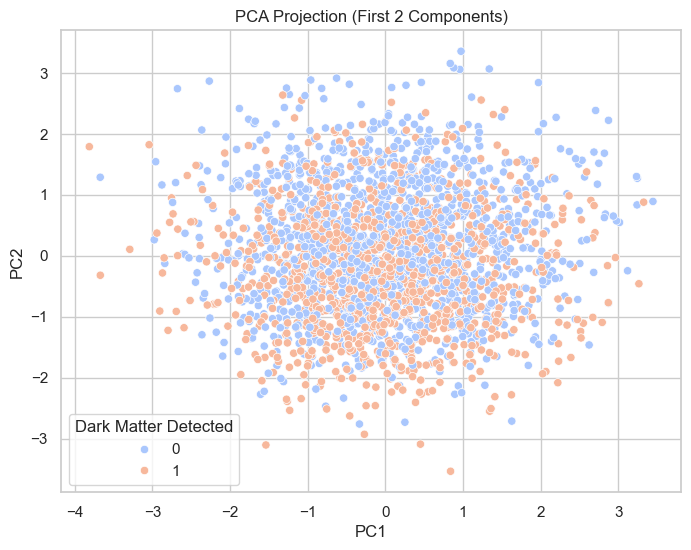

Explained variance ratio (PC1, PC2): [0.08842176 0.07880378]


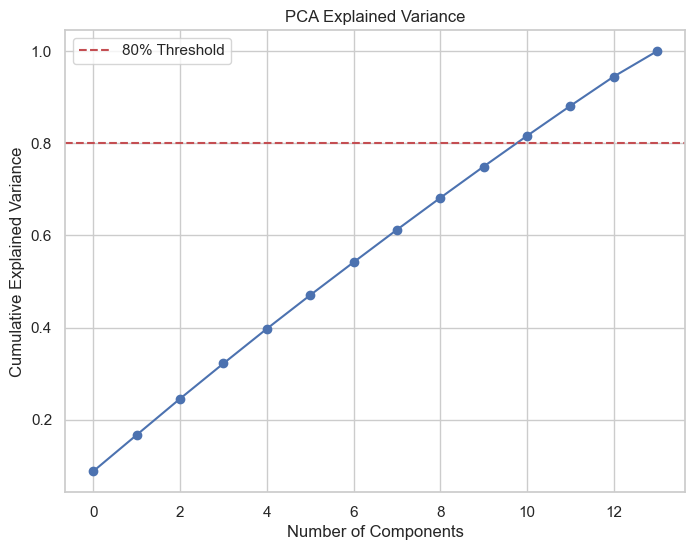

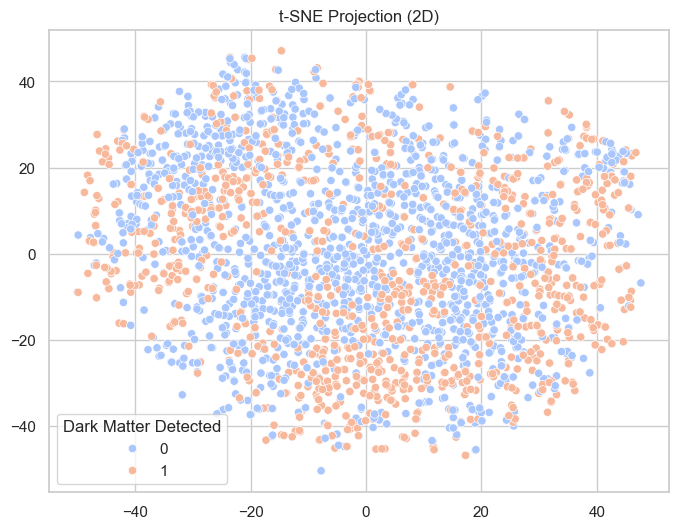

In [29]:
# ==============================
# 2B) Multivariate Analysis
# ==============================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Use numeric features only
num_data = df[num_cols].dropna()

# Scale numeric data
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_data)

# ---- PCA (2D projection) ----
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(num_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1],
                hue=df[target_col].astype(int), palette="coolwarm")
plt.title("PCA Projection (First 2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# ---- PCA cumulative variance ----
pca_full = PCA().fit(num_scaled)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.axhline(y=0.8, color="r", linestyle="--", label="80% Threshold")
plt.legend()
plt.grid(True)
plt.show()

# ---- t-SNE (2D projection, nonlinear) ----
tsne = TSNE(n_components=2, perplexity=30, random_state=42, max_iter=1000)
tsne_result = tsne.fit_transform(num_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1],
                hue=df[target_col].astype(int), palette="coolwarm")
plt.title("t-SNE Projection (2D)")
plt.show()


# Preprocessing

In [30]:
# ==============================
# 4) Build preprocess (NOW, after cat/num exist)
# ==============================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # older sklearn fallback
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)

# Sanity: transformed is non-empty and varies
_tmp = Pipeline([("preprocess", preprocess), ("clf", LogisticRegression(max_iter=100))])
_tmp.fit(X_train, y_train)
Xp = _tmp.named_steps["preprocess"].transform(X_train)
print("Transformed shape:", Xp.shape)
assert Xp.shape[1] > 0, "Preprocess produced 0 columns — check cat/num lists!"


Transformed shape: (2000, 26)


# Define Model

In [31]:
# ==============================
# 5) Models
# ==============================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=400, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=400, max_depth=5, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        eval_metric="logloss", random_state=42, tree_method="hist", n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

pipelines = {name: Pipeline([("preprocess", preprocess), ("clf", mdl)]) for name, mdl in models.items()}


# Evalute Model


🔹 Training Logistic Regression ...
Classification Report:
               precision    recall  f1-score   support

           0      0.846     0.843     0.845       300
           1      0.766     0.770     0.768       200

    accuracy                          0.814       500
   macro avg      0.806     0.807     0.806       500
weighted avg      0.814     0.814     0.814       500



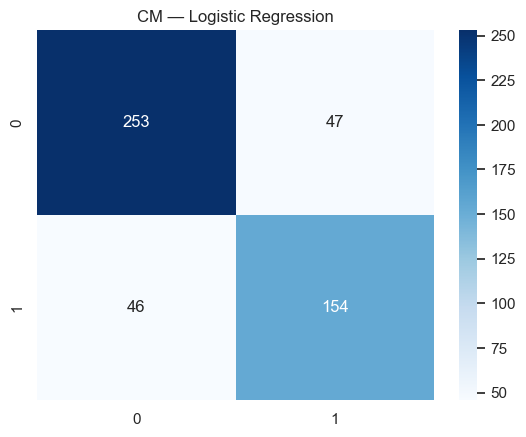


🔹 Training Decision Tree ...
Classification Report:
               precision    recall  f1-score   support

           0      0.767     0.770     0.769       300
           1      0.653     0.650     0.652       200

    accuracy                          0.722       500
   macro avg      0.710     0.710     0.710       500
weighted avg      0.722     0.722     0.722       500



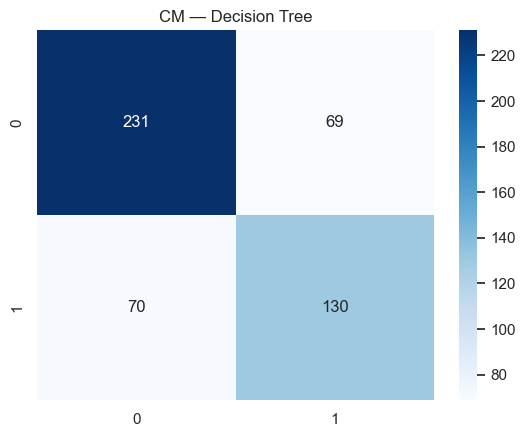


🔹 Training Random Forest ...
Classification Report:
               precision    recall  f1-score   support

           0      0.809     0.860     0.834       300
           1      0.768     0.695     0.730       200

    accuracy                          0.794       500
   macro avg      0.788     0.777     0.782       500
weighted avg      0.792     0.794     0.792       500



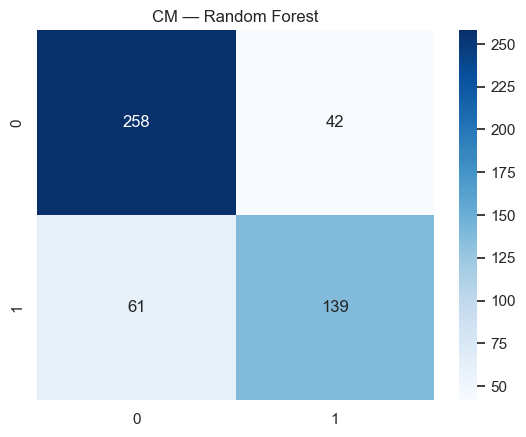


🔹 Training SVM ...
Classification Report:
               precision    recall  f1-score   support

           0      0.817     0.847     0.831       300
           1      0.757     0.715     0.735       200

    accuracy                          0.794       500
   macro avg      0.787     0.781     0.783       500
weighted avg      0.793     0.794     0.793       500



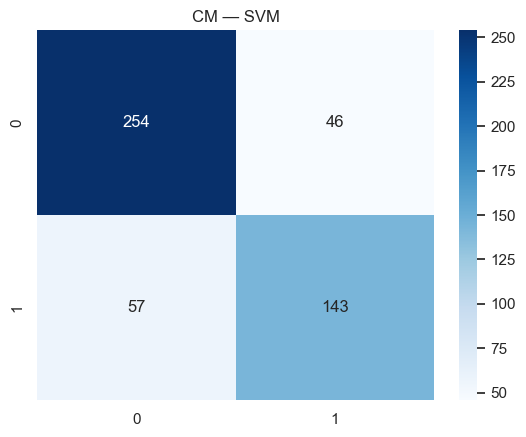


🔹 Training KNN ...
Classification Report:
               precision    recall  f1-score   support

           0      0.740     0.837     0.786       300
           1      0.696     0.560     0.620       200

    accuracy                          0.726       500
   macro avg      0.718     0.698     0.703       500
weighted avg      0.723     0.726     0.720       500



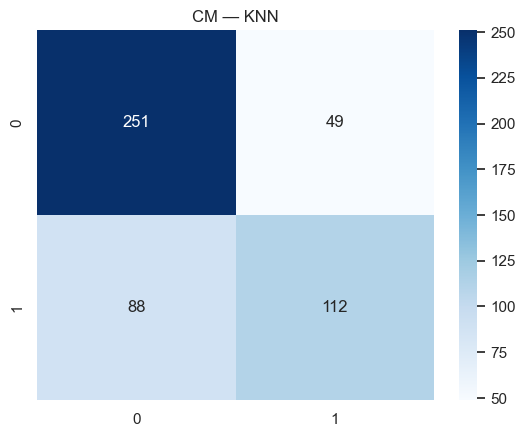


🔹 Training XGBoost ...
Classification Report:
               precision    recall  f1-score   support

           0      0.822     0.817     0.819       300
           1      0.728     0.735     0.731       200

    accuracy                          0.784       500
   macro avg      0.775     0.776     0.775       500
weighted avg      0.784     0.784     0.784       500



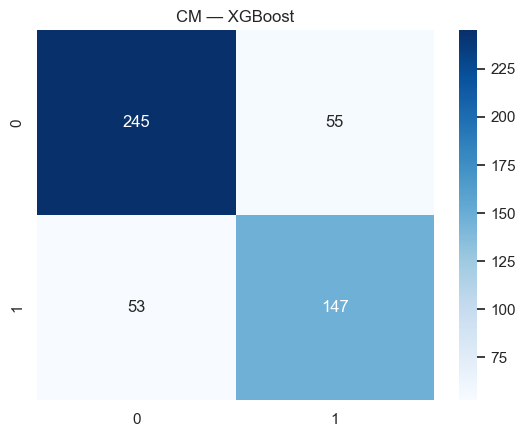


🔹 Training Gradient Boosting ...
Classification Report:
               precision    recall  f1-score   support

           0      0.830     0.843     0.836       300
           1      0.759     0.740     0.749       200

    accuracy                          0.802       500
   macro avg      0.794     0.792     0.793       500
weighted avg      0.801     0.802     0.802       500



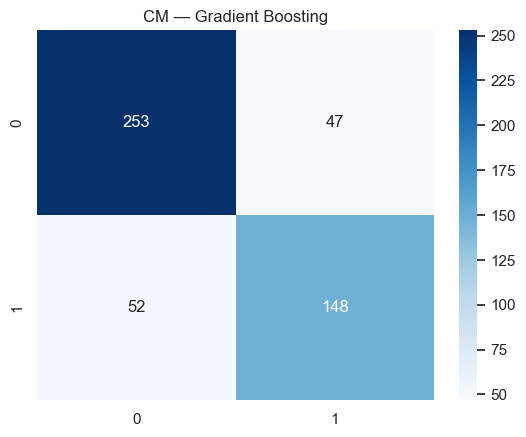


🔹 Training Naive Bayes ...
Classification Report:
               precision    recall  f1-score   support

           0      0.801     0.857     0.828       300
           1      0.760     0.680     0.718       200

    accuracy                          0.786       500
   macro avg      0.780     0.768     0.773       500
weighted avg      0.784     0.786     0.784       500



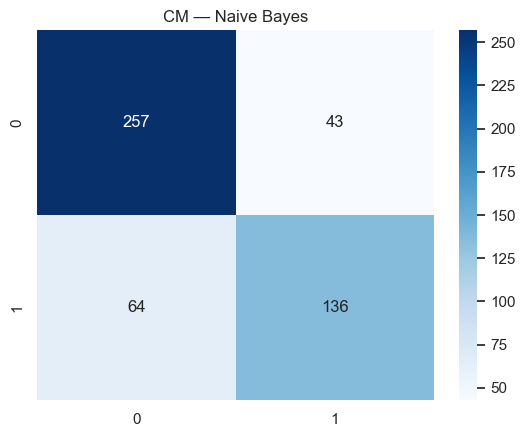

In [32]:
# ==============================
# 6) Evaluate (prob aligned to classes_) + pick best
# ==============================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

scores_table = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    print(f"\n🔹 Training {name} ...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Robust p1 for ROC AUC
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_test)
        est = pipe.named_steps["clf"]
        classes_ = list(getattr(est, "classes_", []))
        p1 = proba[:, classes_.index(1)] if 1 in classes_ else np.max(proba, axis=1)
    elif hasattr(pipe, "decision_function"):
        s = pipe.decision_function(X_test)
        if s.ndim == 1:
            p1 = 1 / (1 + np.exp(-s))
        else:
            e = np.exp(s - s.max(axis=1, keepdims=True))
            p1 = (e/e.sum(axis=1, keepdims=True)).max(axis=1)
    else:
        p1 = (y_pred == 1).astype(float)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    try:
        roc = roc_auc_score(y_test, p1)
    except ValueError:
        roc = np.nan

    # Cross-validated metrics on full X,y
    cv_acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_f1  = cross_val_score(pipe, X, y, cv=cv, scoring="f1", n_jobs=-1)
    cv_roc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues"); plt.title(f"CM — {name}"); plt.show()

    scores_table.append({
        "Model": name,
        "Test Accuracy": acc,
        "Test F1": f1,
        "Test ROC AUC": roc,
        "CV Acc Mean": float(np.mean(cv_acc)),
        "CV F1 Mean": float(np.mean(cv_f1)),
        "CV ROC AUC Mean": float(np.mean(cv_roc)),
    })



# Compare Model

,Model,Test Accuracy,Test F1,Test ROC AUC,CV Acc Mean,CV F1 Mean,CV ROC AUC Mean
0,Logistic Regression,0.814,0.768080,0.895917,0.8256,0.775036,0.894547
1,Gradient Boosting,0.802,0.749367,0.880717,0.8124,0.758726,0.882667
2,XGBoost,0.784,0.731343,0.866017,0.8056,0.750151,0.878197
3,SVM,0.794,0.735219,0.878992,0.8056,0.746625,0.878030
4,Naive Bayes,0.786,0.717678,0.864817,0.8000,0.728322,0.876980
5,Random Forest,0.794,0.729659,0.877450,0.8096,0.746877,0.876813
6,KNN,0.726,0.620499,0.782125,0.7308,0.629469,0.792918
7,Decision Tree,0.722,0.651629,0.710000,0.7120,0.643454,0.701667


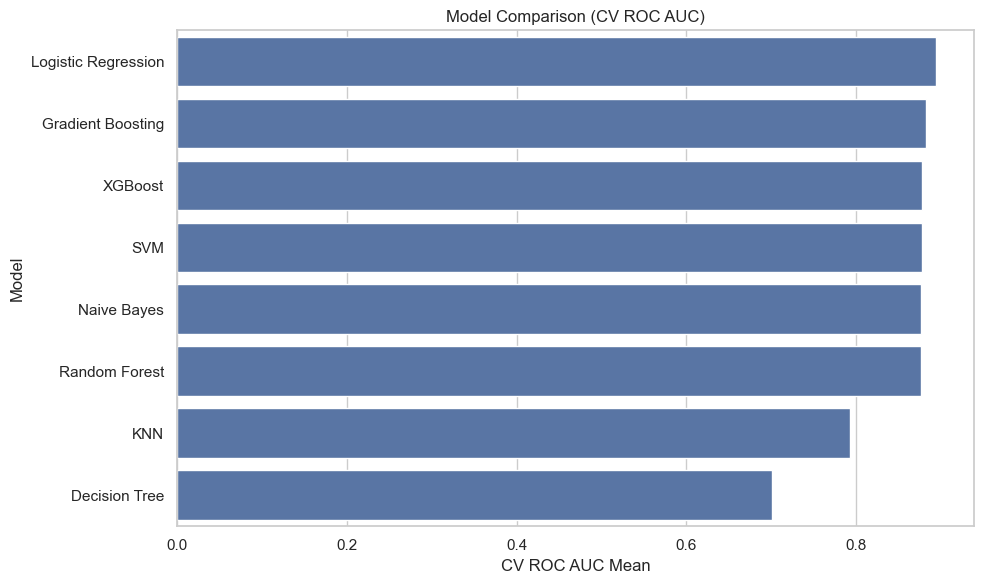


✅ Best Model: Logistic Regression (ROC AUC=0.8945)


In [33]:
# ==============================
# 📌 7. Compare Models
# ==============================

import pandas as pd
results_df = pd.DataFrame(scores_table).sort_values(
    by=["CV ROC AUC Mean","CV F1 Mean","CV Acc Mean"], ascending=False
).reset_index(drop=True)
display(results_df)

# Visualization: CV ROC AUC
plt.figure(figsize=(10,6))
sns.barplot(x="CV ROC AUC Mean", y="Model", data=results_df)
plt.title("Model Comparison (CV ROC AUC)")
plt.tight_layout(); plt.show()

best_model_name = results_df.loc[0, "Model"]
print(f"\n✅ Best Model: {best_model_name} "
      f"(ROC AUC={results_df.loc[0,'CV ROC AUC Mean']:.4f})")

# IMPORTANT: refit best on ALL data for export
best_pipe = pipelines[best_model_name].fit(X, y)


# Feature Importance

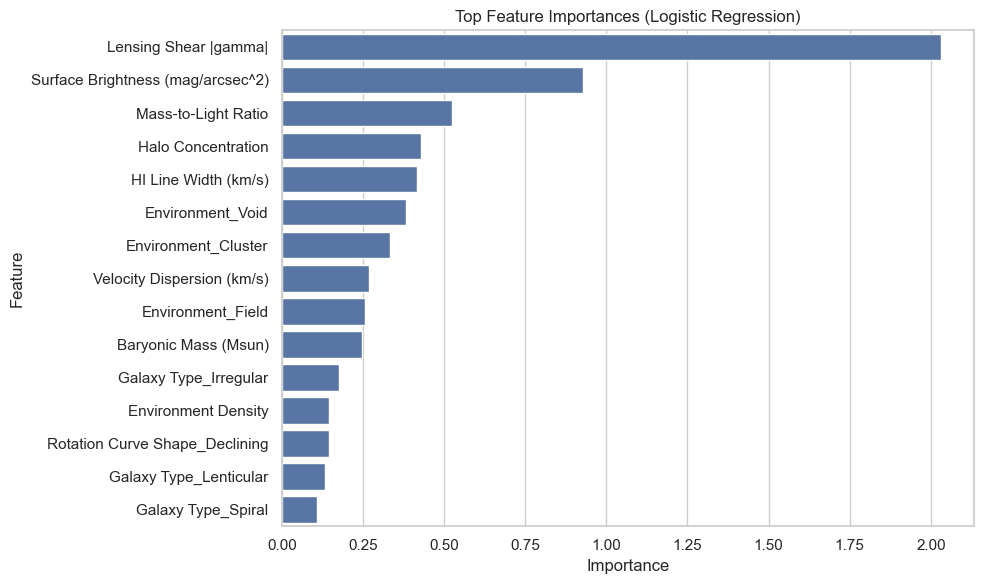

,Feature,Importance
20,Lensing Shear |gamma|,2.031256
14,Surface Brightness (mag/arcsec^2),0.929449
18,Mass-to-Light Ratio,0.524503
19,Halo Concentration,0.429431
16,HI Line Width (km/s),0.415576
11,Environment_Void,0.382826
8,Environment_Cluster,0.334499
15,Velocity Dispersion (km/s),0.270201
9,Environment_Field,0.255560
13,Baryonic Mass (Msun),0.248045


In [34]:
# ==============================
# 7B) Feature Importance
# ==============================

# Get preprocessed feature names (OHE expands categories)
feature_names = []
if cat_cols:
    cat_features = list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
else:
    cat_features = []
feature_names = cat_features + num_cols

# Extract underlying model
final_model = best_pipe.named_steps["clf"]

importances = None

if hasattr(final_model, "feature_importances_"):  # Tree-based models
    importances = final_model.feature_importances_
elif hasattr(final_model, "coef_"):  # Linear/logistic models
    importances = np.abs(final_model.coef_[0])  # take absolute weight
else:
    print(f"Feature importance not supported for {best_model_name}")

if importances is not None:
    feat_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15))
    plt.title(f"Top Feature Importances ({best_model_name})")
    plt.tight_layout()
    plt.show()

    display(feat_imp.head(20))


# Sava best model

In [35]:
# ==============================
# 7) Save for Flask (includes num_bounds)
# ==============================
import pickle, os, hashlib

# Data-driven numeric bounds (used by Flask to keep inputs in-distribution)
num_bounds = {}
for c in num_cols:
    s = X[c].dropna()
    num_bounds[c] = {
        "p01": float(s.quantile(0.01)),
        "p05": float(s.quantile(0.05)),
        "p50": float(s.quantile(0.50)),
        "p95": float(s.quantile(0.95)),
        "p99": float(s.quantile(0.99)),
        "min": float(s.min()),
        "max": float(s.max()),
    }

bundle = {
    "pipeline": best_pipe,
    "cat_cols": cat_cols,
    "num_cols": num_cols,
    "feature_order": list(X.columns),
    "num_bounds": num_bounds,
}

with open("app/models/best_pipeline.pkl", "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)

# Sanity: check file exists, size, and md5
path = "app/models/best_pipeline.pkl"
assert os.path.exists(path), "best_pipeline.pkl was not written!"
print("size bytes:", os.path.getsize(path))

h = hashlib.md5(open(path, "rb").read()).hexdigest()
print("md5:", h)


size bytes: 4905
md5: 2ca7e387ffff3029996e945aa62f0544


# Update The Web Appplication

In [36]:
!docker compose up -d --build --remove-orphans

[+] Building 0.0s (0/1)                                                         
 => [internal] load local bake definitions                                 0.0s
[+] Building 0.1s (1/2)                                                         
 => [internal] load local bake definitions                                 0.0s
 => => reading from stdin 559B                                             0.0s
[+] Building 0.3s (2/3)                                                         
 => [internal] load local bake definitions                                 0.0s
 => => reading from stdin 559B                                             0.0s
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 662B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.12-slim        0.2s
[+] Building 0.5s (2/3)                                                         
 => [internal] load local bake defin